In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2' # set GPU id to use
import sys
import numpy as np
import pandas as pd
from importlib import reload
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False, 'svg.fonttype': 'none' }
plt.rcParams.update(new_rc_params)
# from biock.plot._plot import set_spines, get_figure_size
sys.path.append("../scripts")
from utils import set_spines, get_figure_size

In [2]:
# run python script to generate data
# if pre-computed data is available, users can skip this step by commenting out the following line
! ./pipeline.sh acc

- load processed genome: /bigdat1/pub/UCSC/hg19/bigZips/hg19.fa.cache.pkl
Loading bed: /home/chenken/Documents/github/SpliceBERT/examples/data/gencode.v41lift37.canonical.tx.bed.gz: 37770it [00:00, 377901.28it/s]
100%|█████████████████████████████████████| 12500/12500 [05:54<00:00, 35.24it/s]
(array([0, 1], dtype=int8), array([4159512, 3486689]))
torch.Size([7646201]) torch.Size([7646201, 10]) torch.Size([7646201, 10]) (7646201, 12) (7646201,)
#region	n	acc_vert	acc_human	ece_vert	ece_human
all	.	0.638	0.635	2.225	2.227

#region	n	acc	acc(repeat)	acc(non-repeat)
protein_coding|UTR5	20976/1939/19037	0.455	0.631	0.439
protein_coding|CDS	175258/2147/173111	0.493	0.705	0.491
protein_coding|intron	5272599/2392477/2880122	0.641	0.699	0.545
protein_coding|near_donor	86307/5284/81023	0.486	0.673	0.473
protein_coding|deep_intronic_region	5105738/2382834/2722904	0.643	0.699	0.542
protein_coding|near_acceptor	85692/4627/81065	0.487	0.680	0.476
protein_coding|UTR3	181506/35788/145718	0.490	0.693	0

In [3]:
## generated by `../scripts/evaluate_mlm_per_region.py`:
vert_bacc = [0.455, 0.493, 0.490, 0.641, 0.511, 0.636]
repeat_bacc = [0.631, 0.705, 0.693, 0.699, 0.624, 0.667]
nr_bacc = [0.439, 0.491, 0.440, 0.545, 0.451, 0.539]

In [4]:
# MLM-ACC: intron/exon $\approx$ 30%
print(vert_bacc[3] / np.mean(vert_bacc[:3]))
print(vert_bacc[-1] / vert_bacc[2])

1.3372739916550764
1.2979591836734694


In [6]:
protein_coding_stats = list()
for regions in ["UTR5", "CDS", "UTR3", "intron"]:
    fn = f"../data/genomic_function_region/genomic_function_region.protein_coding.{regions}.bed.gz"
    df = pd.read_csv(fn, sep="\t", header=None, compression="gzip")
    lengths = (df[2] - df[1]).to_numpy()
    total = np.sum(lengths)
    fn = f"../data/genomic_function_region/genomic_function_region.protein_coding.{regions}.in_repeat.bed.gz"
    df = pd.read_csv(fn, sep="\t", header=None, compression="gzip")
    lengths = (df[2] - df[1]).to_numpy()
    repeat = np.sum(lengths)
    print(regions, repeat/total)
    protein_coding_stats.append((regions, repeat/total))

lncRNA_stats = list()
for regions in ["exon", "intron"]:
    fn = f"../data/genomic_function_region/genomic_function_region.lncRNA.{regions}.bed.gz"
    df = pd.read_csv(fn, sep="\t", header=None, compression="gzip")
    lengths = (df[2] - df[1]).to_numpy()
    total = np.sum(lengths)
    fn = f"../data/genomic_function_region/genomic_function_region.lncRNA.{regions}.in_repeat.bed.gz"
    df = pd.read_csv(fn, sep="\t", header=None, compression="gzip")
    lengths = (df[2] - df[1]).to_numpy()
    repeat = np.sum(lengths)
    print(regions, repeat/total)
    lncRNA_stats.append((regions, repeat/total))

UTR5 0.16090193938055766
CDS 0.023379456022206722
UTR3 0.1835823370933863
intron 0.46058405468079067
exon 0.37060982097890793
intron 0.5126231687939264


/tmp/ipykernel_2212445/2447154200.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}%" for x in ax.get_yticks() * 100])


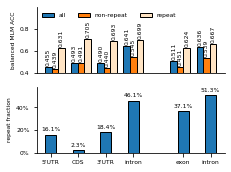

In [7]:
inds = np.asarray([0, 1, 2, 3, 4.8, 5.8])

fs = 6
# set xlabel/ylabel fontsize
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=get_figure_size(0.4, 0.6 * 0.5))


ax = axs[0]
width = 0.25
ax.set_ylabel("balanced MLM ACC")
# ax.set_xticks(inds)
ax.set_xticks([])
set_spines(ax)
ax.bar(x=inds - width, height=vert_bacc, width=width, edgecolor="black", color="tab:blue")
ax.bar(x=inds, height=nr_bacc, width=width, edgecolor="black", color="tab:orange")
ax.bar(x=inds + width, height=repeat_bacc, width=width, edgecolor="black", color="bisque")
ax.set_ylim(0.4, 1)
# annotate the bars
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], vert_bacc)):
    ax.text(x=inds[i] - width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], nr_bacc)):
    ax.text(x=inds[i], y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], repeat_bacc)):
    ax.text(x=inds[i] + width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)

ax.set_yticks([0.4, 0.6, 0.8])
ax.legend(["all", "non-repeat", "repeat"], loc="upper left", frameon=False, fontsize=fs, ncol=3)

ax = axs[1]
set_spines(ax)
width = 0.4
ax.bar(x=inds, height=[x[1] for x in protein_coding_stats + lncRNA_stats], width=width, edgecolor="black", color="tab:blue")
# annotate the bars
for i, (regions, repeat) in enumerate(protein_coding_stats + lncRNA_stats):
    ax.text(x=inds[i], y=repeat + 0.02, s=f"{100 * repeat:.1f}%", ha="center", va="bottom", fontsize=fs)
ax.set_ylabel("repeat fraction")
ax.set_ylim(0, 0.58)
ax.set_xticks(inds)
ax.set_xticklabels(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"])
ax.set_yticklabels([f"{x:.0f}%" for x in ax.get_yticks() * 100])





# legend in 2 columns
# ax.legend(handles, labels, loc="upper left", frameon=False, fontsize=fs, ncol=2)
ax.set_xticks(inds)
ax.set_xticklabels(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"])
ax.set_yticks([0, 0.2, 0.4])
# ax.set_yl

plt.tight_layout()
plt.savefig("repeat_fraction.svg", bbox_inches="tight", transparent=False)
plt.savefig("repeat_fraction.jpg", dpi=600)

In [37]:
## generated by `../scripts/evaluate_mlm_per_region.py`:
dnabert3_bacc = [0.263, 0.274, 0.306, 0.405, 0.335, 0.404]
dnabert3_repeat_bacc = [0.493, 0.538, 0.555, 0.575, 0.500, 0.546]
dnabert3_nr_bacc = [0.249, 0.270, 0.251, 0.259, 0.262, 0.250]

dnabert5_bacc = [0.157, 0.154, 0.187, 0.262, 0.194, 0.261]
dnabert5_repeat_bacc = [0.279, 0.423, 0.378, 0.381, 0.301, 0.360]
dnabert5_nr_bacc = [0.153, 0.152, 0.145, 0.150, 0.150, 0.148]

dnabert4_bacc = [0.198, 0.205, 0.334, 0.252, 0.258, 0.329]
dnabert4_repeat_bacc = [0.454, 0.444, 0.483, 0.483, 0.385, 0.451]
dnabert4_nr_bacc = [0.189, 0.202, 0.202, 0.201, 0.201, 0.195]

dnabert6_bacc = [0.141, 0.120, 0.212, 0.152, 0.167, 0.216]
dnabert6_repeat_bacc = [0.289, 0.341, 0.306, 0.298, 0.264, 0.298]
dnabert6_nr_bacc = [0.131, 0.118, 0.120, 0.120, 0.124, 0.116]

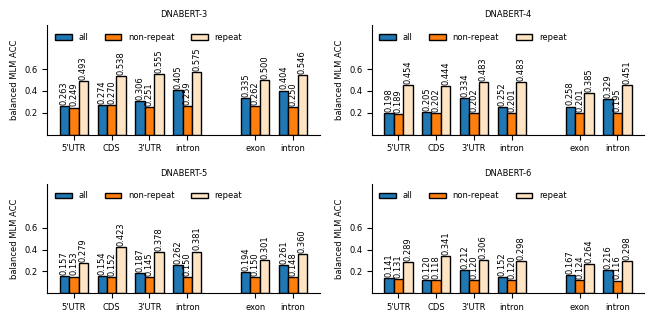

In [39]:
inds = np.asarray([0, 1, 2, 3, 4.8, 5.8])

fs = 6
# set xlabel/ylabel fontsize
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=get_figure_size(0.8, 0.4))


ax = axs[0, 0]
width = 0.25
ax.set_ylabel("balanced MLM ACC")
ax.set_title("DNABERT-3", fontsize=fs)
# ax.set_xticks(inds)
ax.set_xticks([])
set_spines(ax)
ax.bar(x=inds - width, height=dnabert3_bacc, width=width, edgecolor="black", color="tab:blue")
ax.bar(x=inds, height=dnabert3_nr_bacc, width=width, edgecolor="black", color="tab:orange")
ax.bar(x=inds + width, height=dnabert3_repeat_bacc, width=width, edgecolor="black", color="bisque")
ax.set_ylim(0.0, 1)
# annotate the bars
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert3_bacc)):
    ax.text(x=inds[i] - width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert3_nr_bacc)):
    ax.text(x=inds[i], y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert3_repeat_bacc)):
    ax.text(x=inds[i] + width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)

ax.set_yticks([0.2, 0.4, 0.6])
ax.legend(["all", "non-repeat", "repeat"], loc="upper left", frameon=False, fontsize=fs, ncol=3)

ax.set_xticks(inds)
ax.set_xticklabels(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"])

ax = axs[0, 1]
width = 0.25
ax.set_ylabel("balanced MLM ACC")
ax.set_title("DNABERT-4", fontsize=fs)
# ax.set_xticks(inds)
ax.set_xticks([])
set_spines(ax)
ax.bar(x=inds - width, height=dnabert4_bacc, width=width, edgecolor="black", color="tab:blue")
ax.bar(x=inds, height=dnabert4_nr_bacc, width=width, edgecolor="black", color="tab:orange")
ax.bar(x=inds + width, height=dnabert4_repeat_bacc, width=width, edgecolor="black", color="bisque")
ax.set_ylim(0.0, 1)
# annotate the bars
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert4_bacc)):
    ax.text(x=inds[i] - width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert4_nr_bacc)):
    ax.text(x=inds[i], y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert4_repeat_bacc)):
    ax.text(x=inds[i] + width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)

ax.set_yticks([0.2, 0.4, 0.6])
ax.legend(["all", "non-repeat", "repeat"], loc="upper left", frameon=False, fontsize=fs, ncol=3)

ax.set_xticks(inds)
ax.set_xticklabels(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"])



ax = axs[1, 0]
width = 0.25
ax.set_ylabel("balanced MLM ACC")
ax.set_title("DNABERT-5", fontsize=fs)
# ax.set_xticks(inds)
ax.set_xticks([])
set_spines(ax)
ax.bar(x=inds - width, height=dnabert5_bacc, width=width, edgecolor="black", color="tab:blue")
ax.bar(x=inds, height=dnabert5_nr_bacc, width=width, edgecolor="black", color="tab:orange")
ax.bar(x=inds + width, height=dnabert5_repeat_bacc, width=width, edgecolor="black", color="bisque")
ax.set_ylim(0.0, 1)
# annotate the bars
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert5_bacc)):
    ax.text(x=inds[i] - width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert5_nr_bacc)):
    ax.text(x=inds[i], y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert5_repeat_bacc)):
    ax.text(x=inds[i] + width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)

ax.set_yticks([0.2, 0.4, 0.6])
ax.legend(["all", "non-repeat", "repeat"], loc="upper left", frameon=False, fontsize=fs, ncol=3)

ax.set_xticks(inds)
ax.set_xticklabels(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"])


ax = axs[1, 1]
width = 0.25
ax.set_ylabel("balanced MLM ACC")
ax.set_title("DNABERT-6", fontsize=fs)
# ax.set_xticks(inds)
ax.set_xticks([])
set_spines(ax)
ax.bar(x=inds - width, height=dnabert6_bacc, width=width, edgecolor="black", color="tab:blue")
ax.bar(x=inds, height=dnabert6_nr_bacc, width=width, edgecolor="black", color="tab:orange")
ax.bar(x=inds + width, height=dnabert6_repeat_bacc, width=width, edgecolor="black", color="bisque")
ax.set_ylim(0.0, 1)
# annotate the bars
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert6_bacc)):
    ax.text(x=inds[i] - width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert6_nr_bacc)):
    ax.text(x=inds[i], y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)
for i, (regions, bacc) in enumerate(zip(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"], dnabert6_repeat_bacc)):
    ax.text(x=inds[i] + width, y=bacc + 0.01, s=f"{bacc:.3f}", ha="center", va="bottom", fontsize=fs, rotation=90)

ax.set_yticks([0.2, 0.4, 0.6])
ax.legend(["all", "non-repeat", "repeat"], loc="upper left", frameon=False, fontsize=fs, ncol=3)

ax.set_xticks(inds)
ax.set_xticklabels(["5'UTR", "CDS", "3'UTR", "intron", "exon", "intron"])



plt.tight_layout()
plt.savefig("dnabert_mlm_acc.pdf", bbox_inches="tight", transparent=False)
# plt.savefig("dnabertrepeat_fraction.jpg", dpi=600)